In [1]:

import kagglehub
dataset_path = kagglehub.dataset_download('sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons')

print('Data source import complete.')
dataset_path

/home/dev/PycharmProjects/Dream11/.venv1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data source import complete.


'/home/dev/.cache/kagglehub/datasets/sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons/versions/1'

In [2]:


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



In [3]:

class FantasyData(Dataset):
    def __init__(self, df,device):
        self.x, self.y = self.preprocess_data(df)
        self.device = device
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx].to(self.device), self.y[idx].to(self.device)
    def proc_new_data(self,df):
        teams = self.team_enc.transform(df[['venue']])

        fullname_idx = self.le.fit_transform(df['fullName'])

        season_scaled = self.scaler.transform(df[['season']])
        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        teams_tensor = torch.tensor(teams, dtype=torch.float32)
        name_indices = torch.tensor(fullname_idx, dtype=torch.long)
        name_embeddings = self.fullname_embedding(name_indices)

        # Final features [season + teams + embeddings]
        x = torch.cat([
            season_tensor,
            teams_tensor,
            name_embeddings
        ], dim=1)
        return x

    def preprocess_data(self, df):
        # Targets
        y = torch.tensor(
            df[['Batting_FP', 'Bowling_FP', 'Fielding_FP', 'Total_FP']].values,
            dtype=torch.float32
        )
        print(y)
        # Compute sums for each column
        positive_sums = torch.sum(y * (y > 0), dim=0)  # Sum of positive values
        negative_sums = torch.sum(-y * (y < 0), dim=0)  # Sum of negative values

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        scale_factors = positive_sums / (negative_sums + epsilon)
        scale_factors = scale_factors.unsqueeze(0) * 0.05  # Shape: (1, 4)

        # Apply scaling only to negative values (correct broadcasting)
        y = torch.where(y < 0, y * scale_factors, y)
        print(y)



        # 1. Encode fullName
        self.le = LabelEncoder()
        fullname_idx = self.le.fit_transform(df['fullName'])
        self.fullname_embedding = nn.Embedding(
            num_embeddings=len(self.le.classes_),
            embedding_dim=16
        )

        # 2. One-hot encode teams
        self.team_enc = OneHotEncoder(sparse_output=False)
        teams = self.team_enc.fit_transform(df[['venue']])

        # 3. Process season
        self.scaler = MinMaxScaler()
        season_scaled = self.scaler.fit_transform(df[['season']])

        # Convert to tensors and combine
        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        teams_tensor = torch.tensor(teams, dtype=torch.float32)
        name_indices = torch.tensor(fullname_idx, dtype=torch.long)
        name_embeddings = self.fullname_embedding(name_indices)

        # Final features [season + teams + embeddings]
        x = torch.cat([
            season_tensor,
            teams_tensor,
            name_embeddings
        ], dim=1)
        print(x.shape)
        return x,y






In [4]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(54,64,bias=True)
        self.lin2 = nn.Linear(64,32,bias=True)
        # self.lin3 = nn.Linear(128,64,bias=True)
        # self.lin4 = nn.Linear(64,32,bias=True)
        self.lin5 = nn.Linear(32,4,bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        # x = self.lin3(x)
        # x = self.relu(x)
        # x = self.lin4(x)
        # x = self.relu(x)
        x = self.lin5(x)
        # x = self.relu(x)
        return x



In [5]:
def train(model, train_data_loader, optimizer, loss_fn):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for data in train_data_loader:
        inputs, labels = data  # Unpack inputs and labels
        inputs = inputs.detach()
        labels = labels.detach()
        optimizer.zero_grad()  # Clear gradients from previous step

        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass (no need for retain_graph=True)
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss

    # Compute average loss over all batches
    avg_loss = total_loss / len(train_data_loader)

    return avg_loss


In [31]:
# import torch

def evaluate(model, eval_data_loader):
    model.eval()  # Set model to evaluation mode
    total_error = torch.zeros(4)  # Assuming 4 output columns
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for data in eval_data_loader:
            inputs, labels = data
            inputs = inputs.detach()
            labels = labels.detach()

            # Forward pass
            outputs = model(inputs)

            # Calculate squared error for each sample and each output
            error = (outputs - labels)**2

            # Sum errors across batches
            total_error += error.sum(dim=0)
            total_samples += labels.size(0)

    # Calculate average error for each column
    avg_error = total_error / total_samples

    return torch.sqrt(avg_error)



In [8]:
df = pd.read_csv(f'{dataset_path}/Final_Fantasy_data.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = FantasyData(df,device)
train_data_loader = DataLoader(data, batch_size=1024,shuffle=True)
criterion  = nn.MSELoss()
model = Model().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.1)
loss_list = []

tensor([[130.,   0.,   0., 134.],
        [  0.,  83.,   8.,  95.],
        [ 71.,   0.,   0.,  75.],
        ...,
        [  1.,   0.,   0.,   5.],
        [  0.,   0.,   0.,   4.],
        [ -2.,   0.,   0.,   2.]])
tensor([[130.0000,   0.0000,   0.0000, 134.0000],
        [  0.0000,  83.0000,   8.0000,  95.0000],
        [ 71.0000,   0.0000,   0.0000,  75.0000],
        ...,
        [  1.0000,   0.0000,   0.0000,   5.0000],
        [  0.0000,   0.0000,   0.0000,   4.0000],
        [-17.7037,   0.0000,   0.0000,   2.0000]])
torch.Size([22362, 54])


In [ ]:
model.load_state_dict(torch.load('model.pth'))


0 787.9297568581321
25 677.308671431108
50 680.2320417924361
75 674.042422207919
100 671.1779452237216
125 667.3304582075639
150 665.167802290483
175 666.0826388272372
200 659.9014476429332
225 666.9648687189275
250 657.3301336115056
275 654.1403503417969
300 657.506650057706
325 656.2176097523082
350 651.8771611993963
375 645.7840631658381
400 644.4134493741122
425 643.2207169966264
450 646.3747031471946
475 639.7974326393821


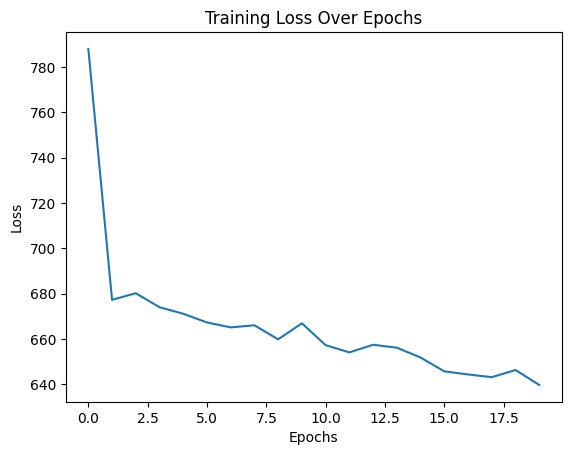

In [15]:
epoch = 500

model.train()
for iter in range(epoch):

    avg_loss = train(model, train_data_loader, optimizer, criterion)

    if iter%100 == 0  :
        print(evaluate(model, train_data_loader))
        loss_list.append(avg_loss)

plt.plot(loss_list)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()



In [32]:
e = evaluate(model, train_data_loader)
e

tensor([23.8668, 22.5976,  5.7473, 37.5171])

In [12]:
test_data = {
    "fullName": ["MS Dhoni", "Virat Kohli","Virat Kohli","Jasprit Bumrah"],
    "season": [2023, 2025,2023,2022],
    "venue":['MA Chidambaram Stadium, Chepauk, Chennai',"M.Chinnaswamy Stadium, Bengaluru","Wankhede Stadium, Mumbai","Wankhede Stadium, Mumbai"]
}

test = pd.DataFrame(test_data)
test

,fullName,season,venue
0,MS Dhoni,2023,"MA Chidambaram Stadium, Chepauk, Chennai"
1,Virat Kohli,2025,"M.Chinnaswamy Stadium, Bengaluru"
2,Virat Kohli,2023,"Wankhede Stadium, Mumbai"
3,Jasprit Bumrah,2022,"Wankhede Stadium, Mumbai"


In [13]:
test_data_1 = data.proc_new_data(test)

In [14]:
model.eval()
for item in test_data_1:
    print([float(_) for _ in model(item)])

[-3.6469192504882812, 30.951391220092773, 1.9262770414352417, 31.19577407836914]
[13.917169570922852, 3.4702651500701904, 4.219391345977783, 25.575416564941406]
[33.869773864746094, -1.931955099105835, 3.7121293544769287, 41.97006607055664]
[8.498597145080566, 4.482673645019531, 2.5589852333068848, 16.60869598388672]


In [33]:
#Do not re run this
# torch.save(model.state_dict() ,"model.pth")

<All keys matched successfully>

device(type='cpu')

In [18]:
torch.cuda.is_available()

False

In [19]:
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cpu
None


In [54]:
df[df['fullName']=="MS Dhoni"].head()


,season,match_id,match_name,home_team,away_team,venue,batting_innings,bowling_innings,fullName,Starting_11,Batting_FP,Bowling_FP,Fielding_FP,Total_FP,Dream Team,Captain,Vice Captain
19,2023,1370353,GT v CSK,GT,CSK,"Narendra Modi Stadium, Motera, Ahmedabad",2,1,MS Dhoni,4,-2,0,20,22,0,0,0
80,2023,1370350,CSK v GT,CSK,GT,"MA Chidambaram Stadium, Chepauk, Chennai",1,2,MS Dhoni,4,1,0,0,5,0,0,0
176,2023,1359541,DC v CSK,DC,CSK,"Arun Jaitley Stadium, Delhi",1,2,MS Dhoni,4,5,0,0,9,0,0,0
319,2023,1359535,CSK v KKR,CSK,KKR,"MA Chidambaram Stadium, Chepauk, Chennai",1,2,MS Dhoni,4,2,0,0,6,0,0,0
456,2023,1359529,CSK v DC,CSK,DC,"MA Chidambaram Stadium, Chepauk, Chennai",1,2,MS Dhoni,4,25,0,0,29,0,0,0


In [56]:
df['venue'].unique()

array(['Narendra Modi Stadium, Motera, Ahmedabad',
       'MA Chidambaram Stadium, Chepauk, Chennai',
       'M.Chinnaswamy Stadium, Bengaluru', 'Wankhede Stadium, Mumbai',
       'Eden Gardens, Kolkata', 'Arun Jaitley Stadium, Delhi',
       'Himachal Pradesh Cricket Association Stadium, Dharamsala',
       'Rajiv Gandhi International Stadium, Uppal, Hyderabad',
       'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow',
       'Sawai Mansingh Stadium, Jaipur',
       'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh',
       'Barsapara Cricket Stadium, Guwahati', 'Brabourne Stadium, Mumbai',
       'Dr DY Patil Sports Academy, Navi Mumbai',
       'Maharashtra Cricket Association Stadium, Pune',
       'Dubai International Cricket Stadium', 'Sharjah Cricket Stadium',
       'Sheikh Zayed Stadium, Abu Dhabi',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam',
       'Holkar Cricket Stadium, Indore', 'Green Park, Kanpur',
  